In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Read the data
INPUT_DIR='../input/m5-forecasting-accuracy/'
cal_data=pd.read_csv(INPUT_DIR+'calendar.csv')
salestv_data=pd.read_csv(INPUT_DIR+'sales_train_validation.csv')
ss_data=pd.read_csv(INPUT_DIR+'sample_submission.csv')
#sellp_data=pd.read_csv(INPUT_DIR+'sell_prices.csv')

In [ ]:
timesteps=14
startDay=0

In [ ]:
salestv_data.shape

In [ ]:
salestv_data.head()

In [ ]:
cal_data.head()

In [ ]:
#sellp_data.head()

In [ ]:
ss_data.tail()

In [ ]:
salestv_data.describe()

In [ ]:
salestv_data.isnull()

In [ ]:
print(salestv_data.info())

In [ ]:
# To reduce memory usage
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int32', 'int64']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [ ]:
salestv_data_downcast = downcast_dtypes(salestv_data)

In [ ]:
print(salestv_data_downcast.info())

In [ ]:
# Making dates as row to get the data in exact format
salestv_data_downcast = salestv_data_downcast.T

In [ ]:
salestv_data_downcast.shape
salestv_data_downcast.head(8)

In [ ]:
#remove first 6 rows as we do not need that to feed to our model
salestv_data_downcast = salestv_data_downcast[6+startDay:]
salestv_data_downcast.head(8)

In [ ]:
# create a dataframe with zeores for 1969 days in the calendar - To store the knowledge if an event exist in the next day
daysBeforeEvent = pd.DataFrame(np.zeros((1969,1)))

In [ ]:
# "1" is assigned to the days before the event_name_1. 
for x, y in cal_data.iterrows():
    if x!=0 and (pd.isnull(cal_data['event_name_1'][x]) == False):
        daysBeforeEvent[0][x-1]=1
#    else if x==0 and (pd.isnull(cal_data['event_name_1'][x]) == False):
#        daysBeforeEvent[0][x]=1

In [ ]:
# daysBeforeEvent is used as a feature and also to train and test the validations 
daysBeforeEventTest = daysBeforeEvent[1913:1941]
daysBeforeEventTrain = daysBeforeEvent[startDay:1913]
print(daysBeforeEventTest.shape)
print(daysBeforeEventTest)

In [ ]:
daysBeforeEventTrain.columns = ['oneDayBeforeEvent']
daysBeforeEventTrain.index = salestv_data_downcast.index

In [ ]:
final_data = pd.concat([salestv_data_downcast, daysBeforeEventTrain], axis=1)
print(final_data)

In [ ]:
# Feature scaling
# Scale the features using MinMaxScaler in range 0-1
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
final_data_scaled = sc.fit_transform(final_data)

print(final_data_scaled)

In [ ]:
final_data_scaled.shape

Here is the important part. "X_train" and "y_train" data is created. For each X_train item, 14 past days' sales and 14 daysBeforeEvent feature are included. So one element of X_train's shape is (14, 30491). For y_train we are predicting one day sales of 30490 items therefore one element of y_train's shape is (1, 30490)

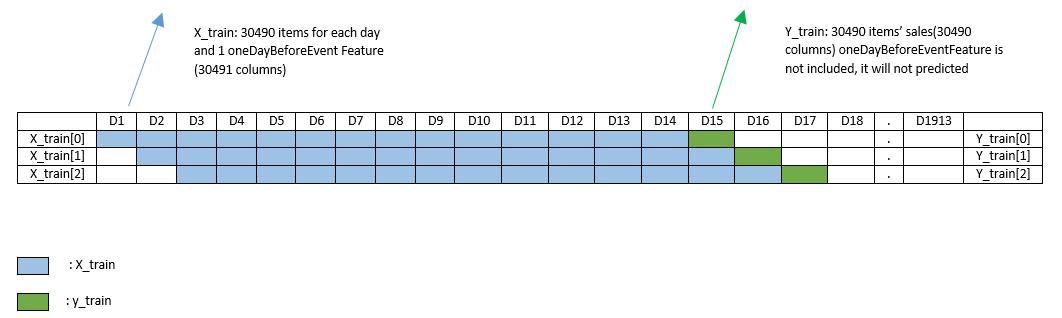

In [ ]:
# creating sequences for LSTM model training
X_train = []
y_train = []

for i in range(timesteps,1913-startDay):
    X_train.append(final_data_scaled[i-timesteps:i])
    y_train.append(final_data_scaled[i][0:30490])
    #İmportant!! if extra features are added (like oneDayBeforeEvent) 
    #use only sales values for predictions (we only predict sales) 
    #this is why 0:30490 columns are choosen

In [ ]:
del final_data_scaled
del cal_data

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

# LSTM model - keras implementation https://www.youtube.com/watch?v=WCUNPb-5EYI

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Initializing the RNN
regressor = Sequential()

# Adding first LSTM layer and some dropout regularization
layer_1_units = 40
regressor.add(LSTM(units=layer_1_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding second LSTM layer and some dropout regularization
layer_2_units = 300
regressor.add(LSTM(units=layer_2_units, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding third LSTM layer and some dropout regularization``
layer_3_units = 300
regressor.add(LSTM(units=layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units=30490))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the trainign set
epoch_no = 32
batch_size_RNN = 44
regressor.fit(X_train, y_train, epochs=epoch_no, batch_size=batch_size_RNN)



In [ ]:
inputs = final_data[-timesteps:]
inputs = sc.transform(inputs)
print(inputs)

* Here is again an important part.
* We are using last 14 days in order to predict day 1915 sales.
* In order to predict 1916th day, 13 days from our input data and 1 day from our prediction are used. After that we slide the window one by one.  
    12 days from input data + 2 days from our prediction to predict 1917th day  
    11 days from input data + 3 days from our prediction to predict 1918th day  
    .....  
    14 days our prediction to predict last 1941th day sale  

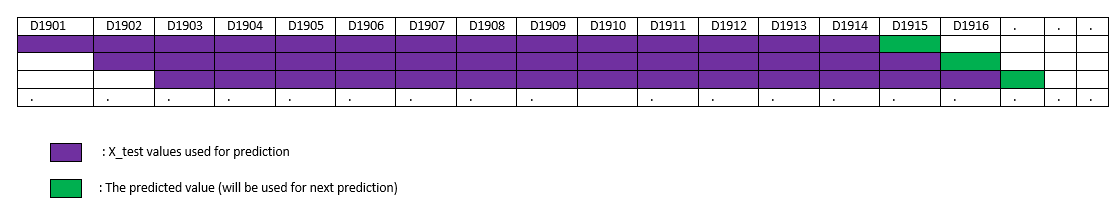

In [ ]:
X_test = []
X_test.append(inputs[0:timesteps])
X_test = np.array(X_test)
print(X_test.shape)
#print(X_test[0, 1:14].shape)
predictions = []

for j in range(timesteps, timesteps+28):
    predicted_sales = regressor.predict(X_test[0, j-timesteps:j].reshape(1, timesteps,30491))
    testInput = np.column_stack((np.array(predicted_sales), daysBeforeEventTest[0][1913+j-timesteps]))
    X_test = np.append(X_test, testInput).reshape(1, j+1, 30491)
    predicted_sales = sc.inverse_transform(testInput)[:,0:30490]
    predictions.append(predicted_sales)
print(testInput.shape)

# File submission

In [ ]:
import time
import matplotlib.pyplot as plt

submission = pd.DataFrame(data=np.array(predictions).reshape(28,30490))
submission = submission.T
submission = pd.concat((submission, submission), ignore_index=True)


sample_submission = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')
idColumn = sample_submission[['id']]
submission[['id']] = idColumn

cols = list(submission.columns)
cols = cols[-1:]+cols[:-1]
submission = submission[cols]

colsdname = ['id'] + [f'F{i}' for i in range(1,29)]
submission.columns = colsdname

currrentDatTime = time.strftime('%d%m%Y_%H%M%S')
#submission.to_csv('submission.csv', index=False)

#fig,axs = plt.subplots(figsize=(15,5))
#d_cols = [c for c in salestv_data.columns if 'd_' in c]
#salestv_data[salestv_data['id'] == 'HOBBIES_1_001_CA_1_validation'][d_cols].T.plot(ax=axs)
#submission[submission['id'] == 'HOBBIES_1_001_CA_1_validation'].set_index('id').T.plot(ax=axs)